# Transfer learnig with an example of fine-tuning ResNet

In [1]:
import glob
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

%matplotlib inline
warnings.filterwarnings("ignore")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cpu'

Download dataset, delete a couple of corrupted pictuures and create loaders.

In [5]:
#!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip --no-check-certificate
#!unzip -qq kagglecatsanddogs_5340.zip
#!rd /s /q PetImages\Cat\666.jpg PetImages\Dog\11702.jpg readme\[1\].txt CDLA-Permissive-2.0.pdf

The directory name is invalid.
The directory name is invalid.
The system cannot find the path specified.
The directory name is invalid.


In [3]:
dataset=ImageFolder(
                    ".\kagglecatsanddogs_5340\PetImages",
                     transform=Compose(
                     [
                         Resize((224, 224)),
                         ToTensor(),
                         Normalize((0.5, 0.5, 0.5), (1, 1, 1)), #data normalization
                     ]
                     )
)

train_set, val_set = torch.utils.data.random_split(
    dataset, 
    [int(0.8* len(dataset)), len(dataset) - int(0.8* len(dataset))] #in train we took 80% of images, in val - 20%
)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=True)

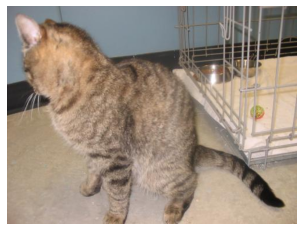

In [4]:
file = np.random.choice(glob.glob(".\kagglecatsanddogs_5340\PetImages\*\*.jpg"))
plt.axis("off")
plt.imshow(plt.imread(file))

## Transfer Learning and Fine-tuning

Fitting of a well-working model sometimes may take a very large period of time.
But, if we have a new dataset which looks like very similar to dataset on which some other model was already fitted we can use such a pretrained model for decreasing of fitting time for our new dataset. Such an approach calls **Transfer Learning**. 

We transfer learning here from already known dataset to a new dataset with similar data. In point of network we change only last layer (fully connected) where classification is located.

Thus, **Transfer Learning** is method of using of pretrained models in fitting, and **Fine-tuning** is a process of setting of pretrained model to your particular problem (fitting pretrained model on your similar data).

In `torchvision` library there are many already implemented models (AlexNet, ResNet, VGG, Inception, Densenet, ResNext, WideResNet, MobileNet, etc.) and also in this library there are checkpoints for models fitted on ImageNet dataset.

(But for Cats vs Dogs, for instance, we haven't checkpoints)

In [2]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchvision.models import resnet18

In [6]:
model = resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In Transfer Learning problem we change the last layer of the neural network to linear layer with some number of outputs (two, if we have binary classification) and "freeze" weights of the other layers.

In [12]:
class CatsvsDogsResNet(pl.LightningModule):
    def __init__(self, pretrained: bool = False) -> None:
        super().__init__()
        self.pretrained = pretrained
        
        self.classification = nn.Linear(1000, 2) # change 1000 classes to 2 classes (dogs and cats)
        self.fc =  self.classification # delete fully connected layer with 1000 classes from original ResNet trained on ImageNet dataset
        
        if pretrained:
            self.model = resnet18(pretrained=True)
            self.optimizer = torch.optim.Adam(self.classification.parameters())
        else:
            self.model = resnet18(pretrained=False)
            self.optimizer = torch.optim.Adam(self.model.parameters())
        
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x) -> torch.Tensor:
        
        if self.pretrained:
            with torch.no_grad():
                x = self.model(x)
            x = self.classification(x)
        else:
            x = self.model(x)
            x = self.classification(x)
            
        return x
    
    def configure_optimizers(self):
        return self.optimizer
    
    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx) -> torch.Tensor:
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)
        
        return loss

In [8]:
cats_vs_dogs_pretrained = CatsvsDogsResNet(pretrained=True)

trainer = pl.Trainer(
    accelerator='cpu',
    max_epochs=1
)

trainer.fit(cats_vs_dogs_pretrained, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name           | Type             | Params
----------------------------------------------------
0 | classification | Linear           | 2.0 K 
1 | model          | ResNet           | 11.7 M
2 | loss           | CrossEntropyLoss | 0     
----------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.766    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [13]:
cats_vs_dogs = CatsvsDogsResNet(pretrained=False)

trainer = pl.Trainer(
    accelerator='cpu',
    max_epochs=1
)

trainer.fit(cats_vs_dogs, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name           | Type             | Params
----------------------------------------------------
0 | classification | Linear           | 2.0 K 
1 | model          | ResNet           | 11.7 M
2 | loss           | CrossEntropyLoss | 0     
----------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.766    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

As you can see, pretrained model even with only one epoch demonstrates much better result than trained on only our data from the beginning.

## Adversarial attacks on example of Fast Gradient Sign Attack

Adversarial attack (in CV) is generation from of an existing data sample an example which for human seems exactly like original data samole, but for neural network the lattest will be considered as an example from another class with VERY big confidense.

One of approaches of such attacks is Fast Gradient Sign Attack (FGSM). The main idea of the approach is:
* We take already trained neural network.
* Calculate gradient on original picture and find out of its sign.
* Multiply gradient sign by some little number value (for instance 0.0001 or smaller, depends of model).
* Add the little value with gradient sign to mathematical representation of original picture and obtain "original" for human picture.
* Send the "original" picture on input of the original model.
* And that's it - the model will recognize the "original" (modified by little value and gradient sign) picture as a picture of another class with very high confidence.

![FGSM Example](panda_FGSM.png)

In [22]:
def fgsm_attack (
    original_image: torch.Tensor,
    epsilon: float,
    data_grad: torch.Tensor
) -> torch.Tensor:
    
    perturbated_image = original_image + epsilon*torch.sign(data_grad)
    
    return perturbated_image

In [23]:
model = nn.Sequential(
    cats_vs_dogs_pretrained.model,
    cats_vs_dogs_pretrained.classification
)

model.eval()

for param in model.parameters():
    param.requires_grad = True

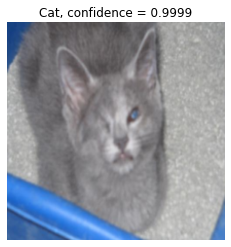

In [24]:
#searching for cat

while True:
    
    idx = np.random.randint(0, len(train_set))
    
    if train_set[idx][1] != 0:
        continue
        
    cat_image = train_set[idx][0]
    break
    

cat_image.requires_grad = True

pred = model(cat_image[None])
predicted_label = pred.argmax(1).item()
confidence = pred.softmax(1)[0][predicted_label]

if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence = %0.4f" % confidence.item())

plt.axis("off")
plt.imshow(cat_image.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


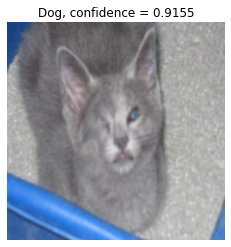

In [25]:
loss = nn.CrossEntropyLoss()(pred, torch.tensor(0).reshape((1,)))
loss.backward() # One step of gradient descent

eps = 0.007

cat_image_perturbated = fgsm_attack(cat_image, eps, cat_image.grad)
pred = model(cat_image_perturbated[None])
predicted_label = pred.argmax(1).item()
confidence = pred.softmax(1)[0][predicted_label]

if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence = %0.4f" % confidence.item())

plt.axis("off")
plt.imshow(cat_image_perturbated.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5);

## Visualization of layers of the network with Shapley Additive Explanations

In [26]:
!pip3 install shap

     -------------------------------------- 462.3/462.3 kB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 5.3 MB/s eta 0:00:00
     ---------------------------------------- 27.7/27.7 MB 4.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Exploring ResNet layers on ImageNet data

Interpretation based on original picture is more easy than based on nearest to output layers because latters are less interpretive.

Each layer in deep CNN pay attention to the filters with increasing difficulty (as layer deepen). The first layers explore main filters such a edges or corners. Middle layers explore filters finding parts of objects - noses or eyes, if you speaking about faces, for instance. And the last layers has more difficult has more difficult information: they learn the whole objects, its shapes or position.

We can use model GradientExplainer which use expected gradients for evaluation of inputs of the different parts of the model. In general, they approximate values of SHAP. We will take 50 samples for counting of expected gradients and evaluate on the signs of first layers of ResNet.

In [3]:
mean = [0.485, 0.456, 0.406] # We counted mean and std before
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image-mean) / std
    # in addition, roll axes so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

In [4]:
import shap
import json

In [5]:
# load proper model (resnet50) and data (imagenet50) from shap wrapper

model = resnet18(pretrained=True).eval()
X, y = shap.datasets.imagenet50()
X /= 255

to_explain = X[[1, 41]]
#load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

fname = shap.datasets.cache(url)

with open(fname) as f:
    class_names = json.load(f)

### Layer 1

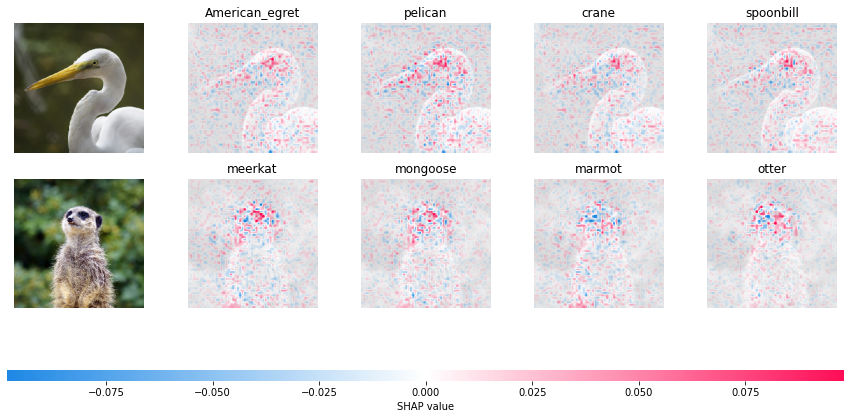

In [6]:
e = shap.GradientExplainer((model, model.layer1[0].conv2), normalize(X))

shap_values, indexes = e.shap_values(normalize(to_explain), ranked_outputs=4, nsamples=50)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

### Layer 2

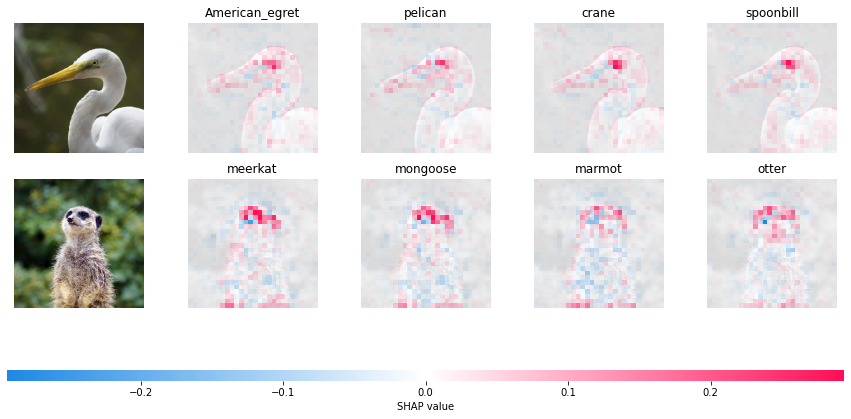

In [7]:
e = shap.GradientExplainer((model, model.layer2[0].conv2), normalize(X))

shap_values, indexes = e.shap_values(normalize(to_explain), ranked_outputs=4, nsamples=50)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)

### Layer 4

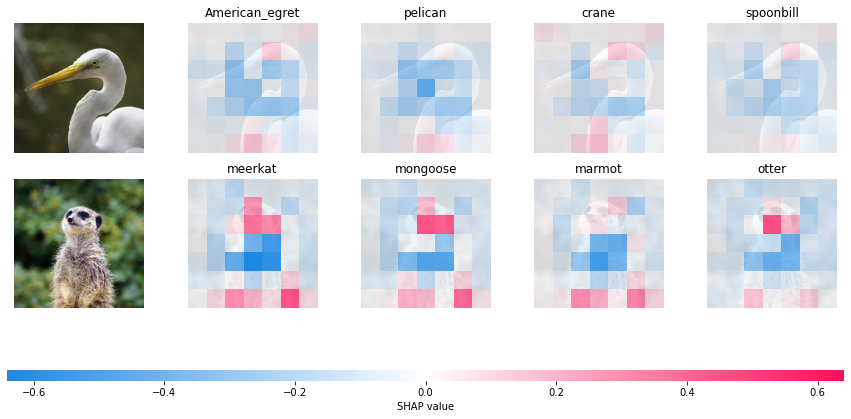

In [8]:
e = shap.GradientExplainer((model, model.layer4[0].conv2), normalize(X))

shap_values, indexes = e.shap_values(normalize(to_explain), ranked_outputs=4, nsamples=50)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

shap.image_plot(shap_values, to_explain, index_names)